In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import scipy.sparse
plt.rc("font", family="serif")
plt.rc("text", usetex=True)
data_path = 'Cadence_microlensing_trainingset_doubles/'
start = 10
end = 11
L_limit = 20
N_images = 2
dt_lower_cut = 2
dt_upper_cut = 150
mag_cut = 23.9

In [104]:
# -------- Read in data --------
files = sorted([f for f in os.listdir(data_path) if not f.startswith('.') if f.endswith(".pkl")
                if os.path.isfile(os.path.join(data_path, f))],
               key=lambda f: f.lower())[start:end]

df = pd.concat([pd.read_pickle(data_path + x) for x in files], ignore_index=True)

af_micro2 = df['acceptance_fraction'].to_numpy()
images = df['time_series'].to_numpy()[:50]
time_stamps = df['time_stamps'].to_numpy()[:50]

In [33]:
print((af_micro2[(np.isfinite(af_micro2)) & (af_micro2 > 1)]))
print(len(af_micro2))
print(np.mean(af_micro2[np.isfinite(af_micro2)]))
print(af_micro2[:20])

[2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1.5 2.  2.  2.  2.  2.  2.  2.
 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
 2.  2.  2.  2.  2.  2.  2.  2.  2. ]
20000
0.7731823109104201
[1.   1.   0.5  0.5  1.   1.   1.   0.25 1.   0.5  0.5  1.   1.   0.5
 0.5  1.   0.5  0.2  0.5  1.  ]


In [5]:
# Drop empty rows (coming from rejected combinations of (z_lens, z_source, theta_E))
time_delay = df['time_delay'].to_numpy()
empty = [ind for ind, x in enumerate(time_delay) if isinstance(x, float)]
df = df.drop(empty)

# Apply cuts
time_delay = df['time_delay'].to_numpy()
peak_brightness_im = df['peak_brightness_im'].to_numpy()
image_x = df['image_x'].to_numpy()
image_y = df['image_y'].to_numpy()

lim_mag = 23.9
x_image, y_image, peak_mags, sep = [], [], [], []

for i in range(len(image_x)):
    x_image.append(np.array(image_x[i]))
    y_image.append(np.array(image_y[i]))
    peak_mags.append(np.array(peak_brightness_im[i]))

x_image = np.array(x_image)
y_image = np.array(y_image)
peak_mags = np.array(peak_mags)
time_delay_1 = np.array([x[-1] for x in time_delay])

if N_images == 2:
    # flux_ratio = 10 ** (peak_mags[:, 1] / -2.5) / 10 ** (peak_mags[:, 0] / -2.5)
    sep = ((x_image[:, 0] - x_image[:, 1]) ** 2 + (y_image[:, 0] - y_image[:, 1]) ** 2) ** 0.5
    peak_im_0 = np.array([x[0] for x in peak_brightness_im])
    peak_im_1 = np.array([x[1] for x in peak_brightness_im])
    indices = (time_delay_1 > dt_lower_cut) & (time_delay_1 < dt_upper_cut) & (peak_im_0 < lim_mag) & \
              (peak_im_1 < mag_cut) & (sep > 0.5) & (sep < 4.0)

# (To count how many remaining lens systems there are)
print("Total systems: ", len(time_delay), "Remaining after cuts: ", len(time_delay[indices]),
      "Fraction: ", np.around(len(time_delay[indices]) / len(time_delay), 2))

# Load all the relevant data properties
data_images = df['time_series'].to_numpy()[indices]
data_zlens = df['z_lens'].to_numpy()[indices]
data_zsource = df['z_source'].to_numpy()[indices]
time_delay_distance = df['time_delay_distance'].to_numpy()[indices]
theta_E = df['theta_E'].to_numpy()[indices]
gamma = df['gamma_lens'].to_numpy()[indices]
H_0 = df['H0'].to_numpy()[indices]
source_x = df['source_x'].to_numpy()[indices]
source_y = df['source_y'].to_numpy()[indices]
image_x = df['image_x'].to_numpy()[indices]
image_y = df['image_y'].to_numpy()[indices]
peak_brightness_im = df['peak_brightness_im'].to_numpy()[indices]
time_delay = df['time_delay'].to_numpy()[indices]
e1 = df['e1_lens'].to_numpy()[indices]
e2 = df['e2_lens'].to_numpy()[indices]
time_stamps = df['time_stamps'].to_numpy()[indices]

Total systems:  2000 Remaining after cuts:  1866 Fraction:  0.93


In [35]:
af_cadence = np.loadtxt(data_path + "data/Acceptance_fractions_cadence.txt")
af_micro = np.loadtxt(data_path + "data/Acceptance_fractions_microlensing.txt")
print(len(af_cadence), len(af_micro))
print(np.mean(af_cadence), np.mean(af_micro[np.isfinite(af_micro)]))
print(len(af_micro[np.isfinite(af_micro)]) / len(af_micro))
print((af_micro[(np.isfinite(af_micro)) & (af_micro > 1)]))
print(af_micro[:20])
print(np.all(af_micro == af_micro2))

20000 20000
0.8091060655769352 0.7731823109104201
0.97815
[2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1.5 2.  2.  2.  2.  2.  2.  2.
 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
 2.  2.  2.  2.  2.  2.  2.  2.  2. ]
[1.   1.   0.5  0.5  1.   1.   1.   0.25 1.   0.5  0.5  1.   1.   0.5
 0.5  1.   0.5  0.2  0.5  1.  ]
True


Mean acceptance fraction due to cadence:  0.8091060655769352
Mean acceptance fraction due to microlensing:  0.7731823109104201


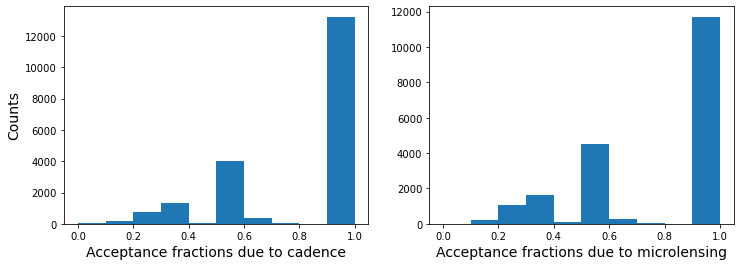

In [79]:
print("Mean acceptance fraction due to cadence: ", np.mean(af_cadence))
print("Mean acceptance fraction due to microlensing: ", np.mean(af_micro[np.isfinite(af_micro)]))

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(af_cadence, range=(0,1), bins=10)
ax[1].hist(af_micro[np.isfinite(af_micro)], range=(0,1), bins=10)
ax[0].set_ylabel("Counts", fontsize=14)
ax[0].set_xlabel("Acceptance fractions due to cadence", fontsize=14)
ax[1].set_xlabel("Acceptance fractions due to microlensing", fontsize=14)
plt.show()

In [90]:
N_accepted = 0

for i in range(len(af_cadence)):
    random_cadence = np.random.uniform(0,1)
    random_micro = np.random.uniform(0,1)
    if random_cadence <= af_cadence[i]:
        if random_micro <= af_micro[i]:
            N_accepted += 1

print("Total simulated lensed SNe in i-band: ", len(af_cadence))
print("Remaining: ", N_accepted)
print("Percentage: ", np.around(N_accepted / len(af_cadence) * 100, 2), "%")
print("From Radek's estimates: ", int(31 * (N_accepted / len(af_cadence))), "glSNe Ia per year (instead of 31)")

Total simulated lensed SNe in i-band:  20000
Remaining:  13068
Percentage:  65.34 %
From Radek's estimates:  20 glSNe Ia per year (instead of 31)


In [103]:
# Find minimum point for log-transform
images_normal = []
images_log = []

for image in range(len(images)):
    
    L = len(images[image])
    
    data_images_notsparse = []
    for i in range(len(images[image])):
        if not scipy.sparse.issparse(images[image][i]):
            data_images_notsparse.append(images[image][i])

    a = 1 - np.min(data_images_notsparse)
    X_log = []
    X_normal = []

    # Loop through observations
    for obs in range(len(images[image])):
        # For a sparse layer: unpack as a dense layer and add to X_temp
        if scipy.sparse.issparse(images[image][obs]):
            X_log.append(np.asarray(images[image][obs].todense()).astype(np.float32))
            X_normal.append(np.asarray(images[image][obs].todense()).astype(np.float32))
            # X_temp.append(np.zeros((48, 48)))

        # For a dense layer: apply log transform and add to X_temp
        else:
            temp_log = np.log(a + images[image][obs])
            # image_max = np.max(temp_log)
            # image_min = np.min(temp_log)
            # temp_scaled = (temp_log - image_min) / (image_max - image_min)
            X_log.append(np.asarray(temp_log).astype(np.float32))
            X_normal.append(np.asarray(images[image][obs]).astype(np.float32))
            # X_temp.append(temp_log)

    filler = np.zeros((48, 48))

    # If L <= 15: the data arrays are filled with filler layers until a length of 15: just add 5 more
    if L <= 15:
        for i in range(5):
            X_log.append(filler)
            X_normal.append(filler)

    # If L > 15 and < L_limit: they need to be filled until the length of the array reaches L_limit
    if 15 < L < L_limit:
        for i in range(L_limit - L):
            X_log.append(filler)
            X_normal.append(filler)

    images_log.append(np.array(X_log))
    images_normal.append(np.array(X_normal))
    
images_log = np.array(images_log)
images_normal = np.array(images_normal)

print(np.shape(images_normal))

(50, 20, 48, 48)


Normal:
9


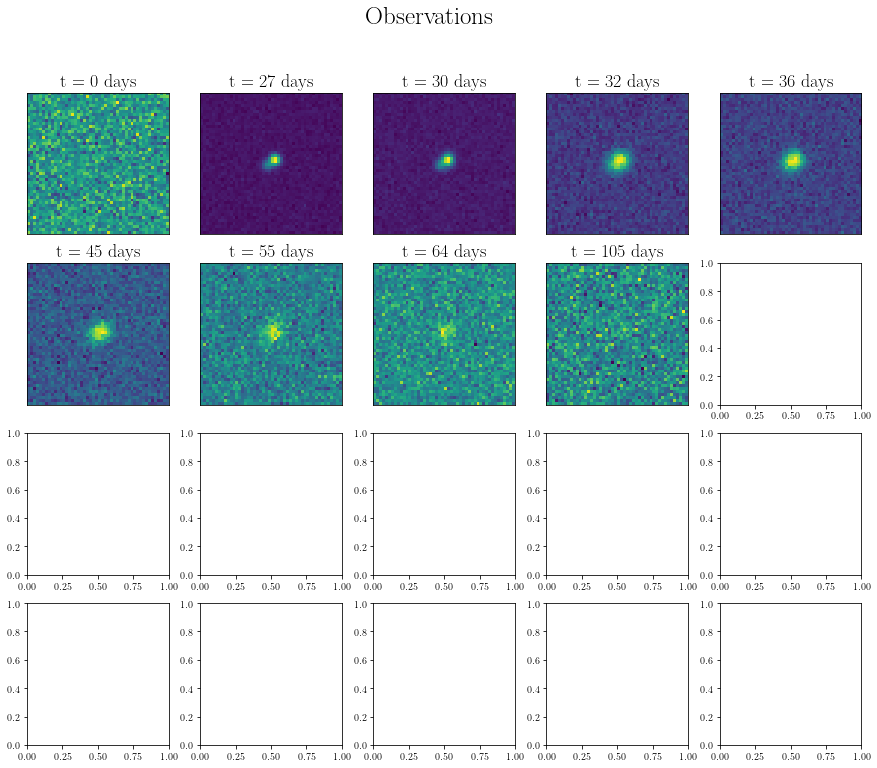

Log:
9


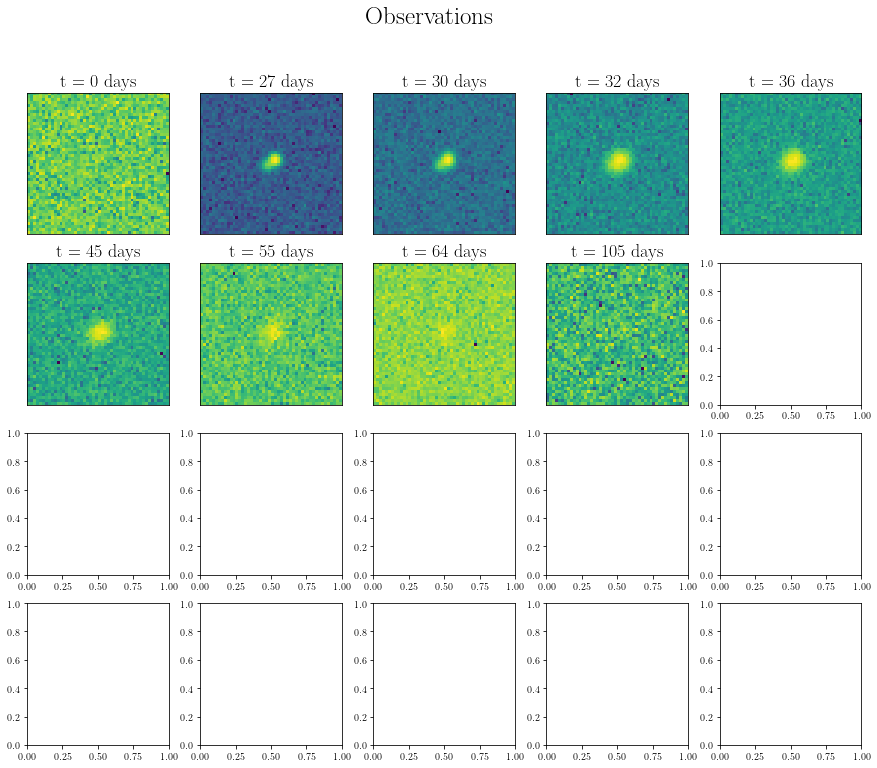

In [135]:

def plot_observations(time_series, time_stamps):

    fig, ax = plt.subplots(4, 5, figsize=(15, 12))
    ax = ax.flatten()
    fig.suptitle("Observations", fontsize=25)
    print(len(time_stamps))

    for s in range(20):
        # Check if an observation exists
        if s < len(time_stamps):
            ax[s].matshow(time_series[s], origin='lower')
            ax[s].set_xticks([])
            ax[s].set_yticks([])
            ax[s].set_title("t = " + str(int(np.around(time_stamps[s], 0))) + " days", fontsize=18)
        else:
            ax[s].set_aspect('equal')

    plt.show()
    
index = 39
print("Normal:")
plot_observations(images_normal[index], time_stamps[index])
print("Log:")
plot_observations(images_log[index], time_stamps[index])

In [136]:
np.savez("glSN_timeseries_images_Doogesh.npz", images_normal=images_normal, images_log=images_log,
         time_stamps=time_stamps)